# Houston Air Quality Data Exploration
____________________
### Patrick Huston, Ezra Varday, Charlie Owen | FA 2017

This notebook presents an initial exploration into the EPA air monitoring data for the Park Place AQ monitoring site in Houston, Texas.

##### Motivating Questions:
- What does air quality look like on an average day in Houston? 
- What are the seasonal dynamics of AQ in Houston? 
- Etc.

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import warnings; warnings.simplefilter('ignore')

sns.set_style("darkgrid")

In [3]:
!ls ../data

338120170929155414557.txt 338120170929160847395.txt


In [4]:
filename = "../data/338120170929155414557.txt"

In [5]:
df1 = pd.read_csv(filename, skiprows=10, sep='|', usecols=range(13), parse_dates={"Datetime" : [10,11]})
df1.tail()

,Datetime,Transaction Type,Action,State Cd,County Cd,Site ID,Parameter Cd,POC,Dur Cd,Unit Cd,Meth Cd,Value
339573,2016-12-30 19:00:00,RD,I,48,201,416,64101,1,1,16,11,1020.89
339574,2016-12-30 20:00:00,RD,I,48,201,416,64101,1,1,16,11,1020.47
339575,2016-12-30 21:00:00,RD,I,48,201,416,64101,1,1,16,11,1019.77
339576,2016-12-30 22:00:00,RD,I,48,201,416,64101,1,1,16,11,1019.07
339577,2016-12-30 23:00:00,RD,I,48,201,416,64101,1,1,16,11,1018.31


In [98]:
df1.set_index('Datetime').head()

,Transaction Type,Action,State Cd,County Cd,Site ID,Parameter Cd,POC,Dur Cd,Unit Cd,Meth Cd,Value
Datetime,,,,,,,,,,,
2014-01-01 00:00:00,RD,I,48,201,416,42101,1,1,7,93,0.16339
2014-01-01 01:00:00,RD,I,48,201,416,42101,1,1,7,93,0.12578
2014-01-01 02:00:00,RD,I,48,201,416,42101,1,1,7,93,0.13623
2014-01-01 03:00:00,RD,I,48,201,416,42101,1,1,7,93,0.19557
2014-01-01 04:00:00,RD,I,48,201,416,42101,1,1,7,93,0.24864


### Parameter Breakdown

| Parameter Code | Meaning                    | Unit Code | Unit        |
|----------------|----------------------------|-----------|-------------|
| 42101          | Carbon dioxide             | 7         | ppm         |
| 42601          | Nitric oxide               | 8         | ppb         |
| 42602          | Nitrogen dioxide           | 8         | ppb         |
| 42603          | NOx                        | 8         | ppb         |
| 42201          | Ozone                      | 8         | ppb         |
| 61101          | Wind spd - scalar          | 12        | mph         |
| 61103          | Wind speed - resultant     | 12        | mph         |
| 61104          | Wind direction - resultant | 14        | deg comp.   |
| 61106          | Std. dev hz wind direction | 14        | deg comp.   |
| 62101          | Outdoor temperature        | 15        | Deg. F      |
| 62103          | Dew point                  | 15        | Deg. F      |
| 62201          | Humidity                   | 19        | % rel. hum  |
| 63301          | Solar radiation            | 25        | Lang/minute |
| 64101          | Barometric pressure        | 16        | Millibars   |

In [58]:
parameter_map = {
    42101: 'carbon_dioxide',
    42601: 'nitric_oxide',
    42602: 'nitrogen_dioxide',
    42603: 'nox',
    44201: 'ozone',
    61101: 'wind_spd_scalar',
    61103: 'wind_spd_resultant',
    61104: 'wind_dir_resultant',
    61106: 'std_dev_wind_dir',
    62101: 'outdoor_tmp',
    62103: 'dew_point',
    62201: 'humidity',
    63301: 'solar_radiation',
    64101: 'barometric_pressure'
}

all_dataframes = {}

for parameter_code, parameter_name in parameter_map.iteritems():
    all_dataframes[parameter_name] = df1.loc[df1['Parameter Cd'] == parameter_code]

In [77]:
all_dataframes['ozone'].describe()

,State Cd,County Cd,Site ID,Parameter Cd,POC,Dur Cd,Unit Cd,Meth Cd,Value
count,25466.0,25466.0,25466.0,25466.0,25466.0,25466.0,25466.0,25466.0,25466.000000
mean,48.0,201.0,416.0,44201.0,1.0,1.0,8.0,47.0,22.452716
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.574847
min,48.0,201.0,416.0,44201.0,1.0,1.0,8.0,47.0,-4.847680
25%,48.0,201.0,416.0,44201.0,1.0,1.0,8.0,47.0,10.815050
50%,48.0,201.0,416.0,44201.0,1.0,1.0,8.0,47.0,20.593750
75%,48.0,201.0,416.0,44201.0,1.0,1.0,8.0,47.0,31.504375
max,48.0,201.0,416.0,44201.0,1.0,1.0,8.0,47.0,135.502000


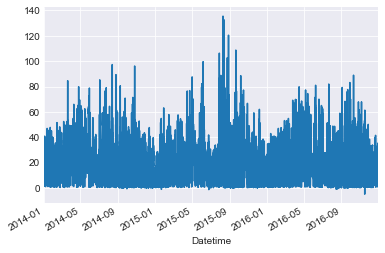

In [150]:
all_dataframes['ozone'].Value.plot()

In [78]:
ozone_df.index = ozone_df.Datetime
ozone_df.sort_index(inplace=True)
ozone_df.head()

,Datetime,Transaction Type,Action,State Cd,County Cd,Site ID,Parameter Cd,POC,Dur Cd,Unit Cd,Meth Cd,Value
Datetime,,,,,,,,,,,,
2014-01-01 00:00:00,2014-01-01 00:00:00,RD,I,48,201,416,44201,1,1,8,47,6.79122
2014-01-01 01:00:00,2014-01-01 01:00:00,RD,I,48,201,416,44201,1,1,8,47,6.61058
2014-01-01 02:00:00,2014-01-01 02:00:00,RD,I,48,201,416,44201,1,1,8,47,5.36760
2014-01-01 03:00:00,2014-01-01 03:00:00,RD,I,48,201,416,44201,1,1,8,47,3.30744
2014-01-01 04:00:00,2014-01-01 04:00:00,RD,I,48,201,416,44201,1,1,8,47,2.86874


In [92]:
ozone_df['doy'] = ozone_df.index.dayofyear

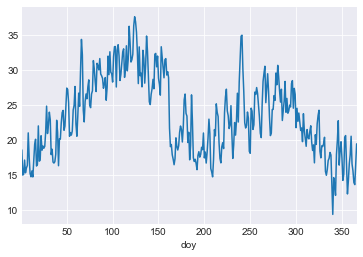

In [159]:
annual_mean = ozone_df.groupby('doy').Value.mean()
annual_mean.plot()

In [93]:
ozone_df['hour'] = ozone_df.index.hour
ozone_df.hour.describe()

count    25466.000000
mean        11.432027
std          6.907731
min          0.000000
25%          5.000000
50%         11.000000
75%         17.000000
max         23.000000
Name: hour, dtype: float64

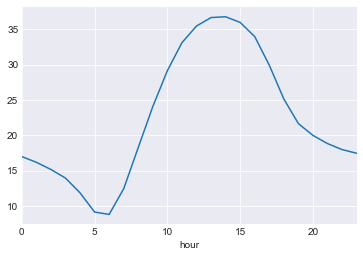

In [147]:
hourly_mean = ozone_df.groupby('hour').Value.mean()
hourly_mean.plot()

In [161]:
parameter_map = {
    42101: 'carbon_dioxide',
    42601: 'nitric_oxide',
    42602: 'nitrogen_dioxide',
    42603: 'nox',
    44201: 'ozone',
    61101: 'wind_spd_scalar',
    61103: 'wind_spd_resultant',
    61104: 'wind_dir_resultant',
    61106: 'std_dev_wind_dir',
    62101: 'outdoor_tmp',
    62103: 'dew_point',
    62201: 'humidity',
    63301: 'solar_radiation',
    64101: 'barometric_pressure'
}


def read_data(filename):
    df1 = pd.read_csv(filename, skiprows=10, sep='|', usecols=range(13), parse_dates={"Datetime" : [10,11]})
    
    all_dataframes = {}

    for parameter_code, parameter_name in parameter_map.iteritems():
        # Get all data for parameter code
        param_df = df1.loc[df1['Parameter Cd'] == parameter_code]
        param_df.index = param_df.Datetime
        param_df.sort_index(inplace=True)
        
        # Set helper fields for datetime breakdowns
        param_df['doy'] = param_df.index.dayofyear
        param_df['hour'] = param_df.index.hour
        param_df['woy'] = param_df.index.weekofyear
        param_df['month'] = param_df.index.month
        param_df['day'] = param_df.index.weekday
        
        # Create extra helper fields
        param_mean = param_df.groupby('woy').Value.mean()
        param_df['annual_mean'] = param_mean[param_df.woy].values
        param_df['detrend'] = param_df.Value - param_df.annual_mean
        all_dataframes[parameter_name] = param_df
    
    return all_dataframes
    

In [167]:
all_data = read_data("../data/338120170929155414557.txt")

In [197]:
def plot_means(fields, group):
    for field in fields:
        plt.plot(all_data[field].groupby(group).Value.mean())
    plt.legend(fields)
    plt.show()

In [1]:
plot_means(['nox', 'ozone','solar_radiation'], 'hour')

NameError: name 'plot_means' is not defined

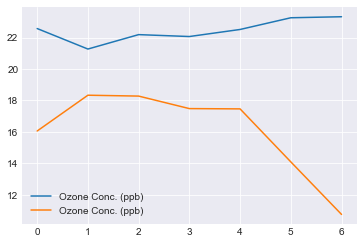

In [168]:
ozone_mean = all_data['ozone'].groupby('day').Value.mean()
nox_mean = all_data['nox'].groupby('day').Value.mean()
ozone_, = plt.plot(ozone_mean, label='Ozone Conc. (ppb)')
nox_, = plt.plot(nox_mean, label='Ozone Conc. (ppb)')
plt.legend(handles=[ozone_, nox_])
plt.show()

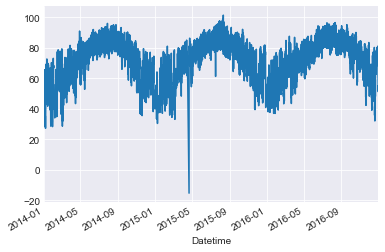

In [169]:
all_data['outdoor_tmp'].Value.plot()

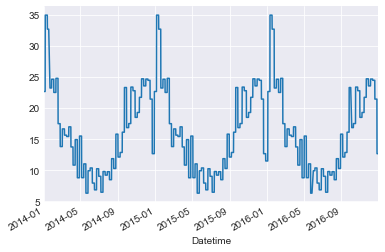

In [170]:
all_data['nox'].annual_mean.plot()

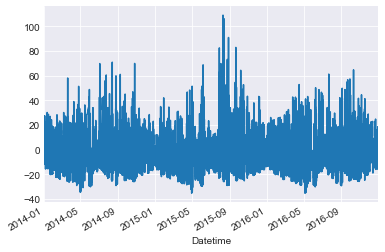

In [172]:
all_data['ozone'].detrend.plot()

In [183]:
def correlation(field_1, field_2):
    return all_data[field_1].detrend.corr(all_data[field_2].detrend)

In [186]:
correlation('ozone', 'solar_radiation')

0.5440505868450517